In [300]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn import tree


In [301]:
# Reading the raw data
dataset = pd.read_csv("bank.csv", index_col= None)
dataset.head(4)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes


In [302]:
dataset.shape

(11162, 17)

In [303]:
#Checking the dtypes of all the columns
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [304]:
# exploring the categorical dataset
cat_data = dataset.select_dtypes(include="object")
for column in cat_data:
    print(cat_data[column].value_counts())
    print ("-" * 20)

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64
--------------------
married     6351
single      3518
divorced    1293
Name: marital, dtype: int64
--------------------
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64
--------------------
no     10994
yes      168
Name: default, dtype: int64
--------------------
no     5881
yes    5281
Name: housing, dtype: int64
--------------------
no     9702
yes    1460
Name: loan, dtype: int64
--------------------
cellular     8042
unknown      2346
telephone     774
Name: contact, dtype: int64
--------------------
may    2824
aug    1519
jul    1514
jun    1222
nov     943
apr     923
feb     776
oct     392
jan     344
sep     319
mar     276
dec     110
Nam

In [305]:
# to determine the number of unknown or null values in the dataset
unknown = [(col ,sum(dataset[col]== 'unknown')) for col in dataset.columns]
print(unknown)

[('age', 0), ('job', 70), ('marital', 0), ('education', 497), ('default', 0), ('balance', 0), ('housing', 0), ('loan', 0), ('contact', 2346), ('day', 0), ('month', 0), ('duration', 0), ('campaign', 0), ('pdays', 0), ('previous', 0), ('poutcome', 8326), ('deposit', 0)]


In [306]:
# dropping rows with null value in job column
dataset.drop(dataset.loc[dataset['job'] == "unknown"].index) 

# Replacing unknown with mode in the education column
dataset['education'].replace("unknown", dataset['education'].mode()[0], inplace = True)

dataset.drop('contact', axis=1, inplace=True) #dropped this property, not relevant
dataset.drop('poutcome', axis=1, inplace=True) #dropped this property since most of data(74.6%) are unknown
dataset.head(4)

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,deposit
0,59,admin.,married,secondary,no,2343,yes,no,5,may,1042,1,-1,0,yes
1,56,admin.,married,secondary,no,45,no,no,5,may,1467,1,-1,0,yes
2,41,technician,married,secondary,no,1270,yes,no,5,may,1389,1,-1,0,yes
3,55,services,married,secondary,no,2476,yes,no,5,may,579,1,-1,0,yes


In [307]:
dataset.tail(4)

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,deposit
11158,39,services,married,secondary,no,733,no,no,16,jun,83,4,-1,0,no
11159,32,technician,single,secondary,no,29,no,no,19,aug,156,2,-1,0,no
11160,43,technician,married,secondary,no,0,no,yes,8,may,9,2,172,5,no
11161,34,technician,married,secondary,no,0,no,no,9,jul,628,1,-1,0,no


# Univariate Analysis

The describe method shows the amount of non-missing values, standard deviation, mode, and median of each numerical highlight (int64, float64) as well as other basic statistical features.

In [308]:
# Description of numerical features in dataset
dataset.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
age,11162.0,41.23,11.91,18.0,32.0,39.0,49.00,95.0
balance,11162.0,1528.54,3225.41,-6847.0,122.0,550.0,1708.00,81204.0
day,11162.0,15.66,8.42,1.0,8.0,15.0,22.00,31.0
duration,11162.0,371.99,347.13,2.0,138.0,255.0,496.00,3881.0
campaign,11162.0,2.51,2.72,1.0,1.0,2.0,3.00,63.0
pdays,11162.0,51.33,108.76,-1.0,-1.0,-1.0,20.75,854.0
previous,11162.0,0.83,2.29,0.0,0.0,0.0,1.00,58.0


In [309]:
# numerical features of the dataset
numerical_features= dataset.select_dtypes(include=['int64', 'float64'])

In [310]:
numerical_features.columns.values

array(['age', 'balance', 'day', 'duration', 'campaign', 'pdays',
       'previous'], dtype=object)

In [311]:
#Changing the target feature (deposit columns) to Int Data type 
dataset['deposit'].replace({'no':0,'yes':1},inplace=True)

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'balance'}>,
        <AxesSubplot:title={'center':'day'}>],
       [<AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'campaign'}>,
        <AxesSubplot:title={'center':'pdays'}>],
       [<AxesSubplot:title={'center':'previous'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

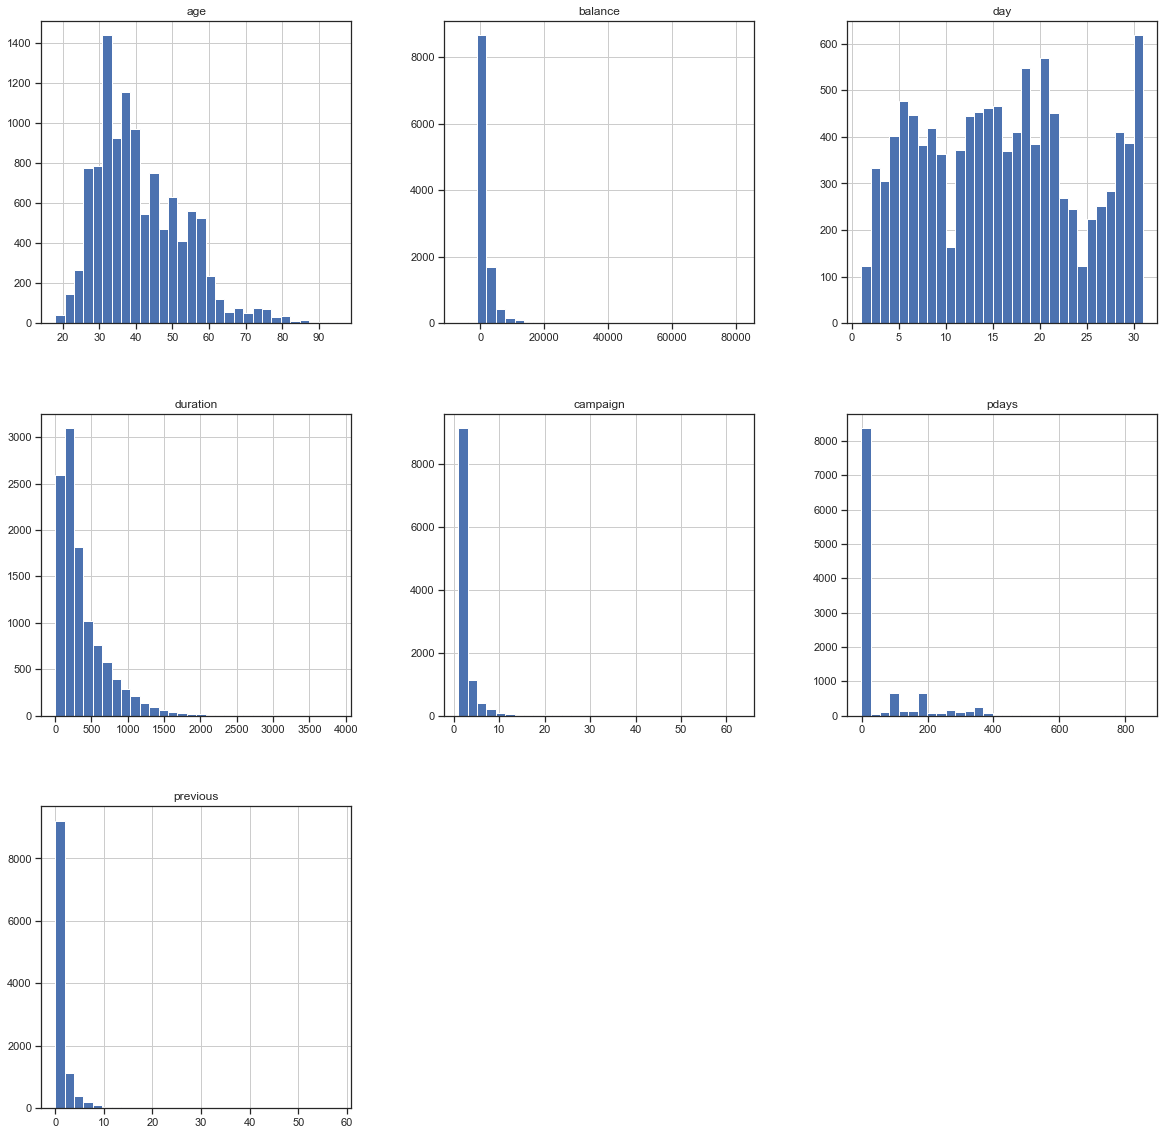

In [312]:
# using histogram to illustrate the numerical features of the dataset in order to analyse the distribution freqency among the features in the dataset
numerical_features.hist(figsize= (20, 20), bins= 30)

In [313]:
# Taking a look at the categorical features
dataset.describe(include=['object'])

,job,marital,education,default,housing,loan,month
count,11162,11162,11162,11162,11162,11162,11162
unique,12,3,3,2,2,2,12
top,management,married,secondary,no,no,no,may
freq,2566,6351,5973,10994,5881,9702,2824


In [314]:
#non-numerical/categorical features
categorical_features = dataset.select_dtypes('object')

In [315]:
categorical_features.values

array([['admin.', 'married', 'secondary', ..., 'yes', 'no', 'may'],
       ['admin.', 'married', 'secondary', ..., 'no', 'no', 'may'],
       ['technician', 'married', 'secondary', ..., 'yes', 'no', 'may'],
       ...,
       ['technician', 'single', 'secondary', ..., 'no', 'no', 'aug'],
       ['technician', 'married', 'secondary', ..., 'no', 'yes', 'may'],
       ['technician', 'married', 'secondary', ..., 'no', 'no', 'jul']],
      dtype=object)

In [316]:
dataset

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,deposit
0,59,admin.,married,secondary,no,2343,yes,no,5,may,1042,1,-1,0,1
1,56,admin.,married,secondary,no,45,no,no,5,may,1467,1,-1,0,1
2,41,technician,married,secondary,no,1270,yes,no,5,may,1389,1,-1,0,1
3,55,services,married,secondary,no,2476,yes,no,5,may,579,1,-1,0,1
4,54,admin.,married,tertiary,no,184,no,no,5,may,673,2,-1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,20,apr,257,1,-1,0,0
11158,39,services,married,secondary,no,733,no,no,16,jun,83,4,-1,0,0
11159,32,technician,single,secondary,no,29,no,no,19,aug,156,2,-1,0,0
11160,43,technician,married,secondary,no,0,no,yes,8,may,9,2,172,5,0


Bivariate Analysis

<AxesSubplot:xlabel='duration', ylabel='count'>

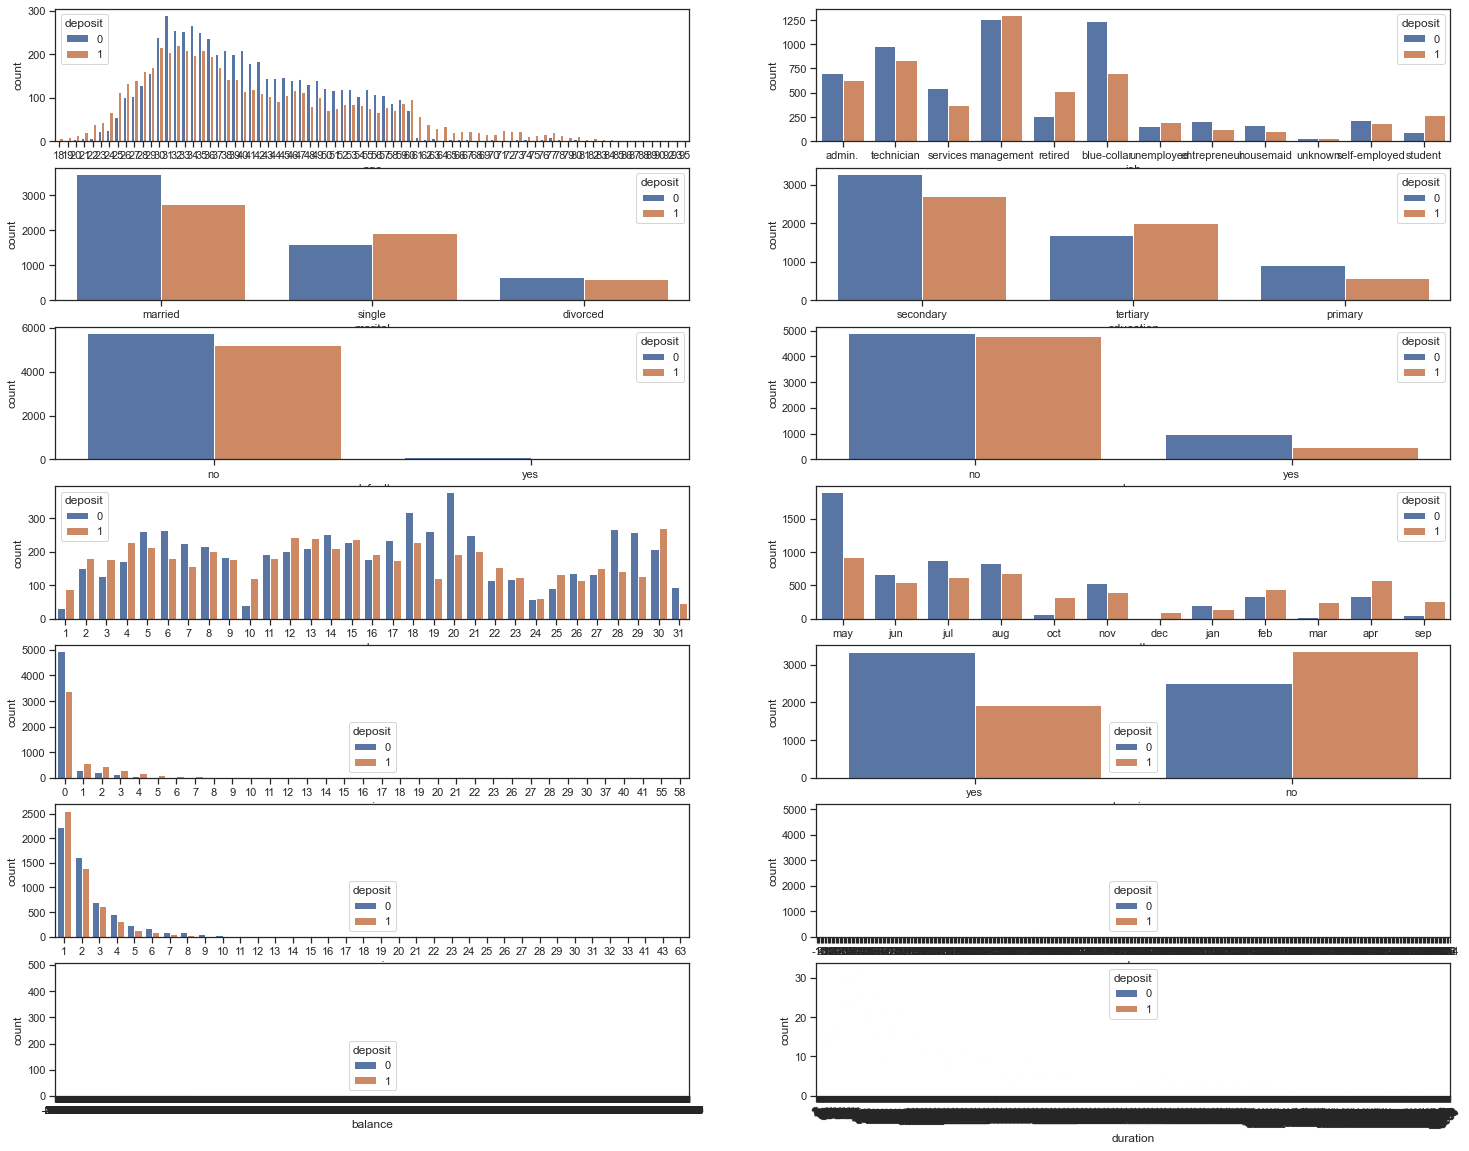

In [317]:
# checking the collaboration of each  columns with deposit variable

fig, ((a,b),(c,d),(e,f),(g,h),(i,j),(k,l),(m,n)) = plt.subplots(7,2,figsize=(25,20))
plt.xticks(rotation=45)
sns.countplot(x='age',hue='deposit', data=dataset,ax=a)
sns.countplot(x='job',hue='deposit', data=dataset,ax=b)
sns.countplot(x='marital',hue='deposit', data=dataset,ax=c)
sns.countplot(x='education',hue='deposit', data=dataset,ax=d)
sns.countplot(x='default',hue='deposit', data=dataset,ax=e)
sns.countplot(x='loan',hue='deposit', data=dataset,ax=f)
sns.countplot(x='day',hue='deposit', data=dataset,ax=g)
sns.countplot(x='month',hue='deposit', data=dataset,ax=h)
sns.countplot(x='previous',hue='deposit', data=dataset,ax=i)
sns.countplot(x='housing',hue='deposit', data=dataset,ax=j)
sns.countplot(x='campaign',hue='deposit', data=dataset,ax=k)
sns.countplot(x='pdays',hue='deposit', data=dataset,ax=l)
sns.countplot(x='balance',hue='deposit', data=dataset,ax=m)
sns.countplot(x='duration',hue='deposit', data=dataset,ax=n)

# Feature Selection

Text(0.5, 1.0, 'Features Correlation')

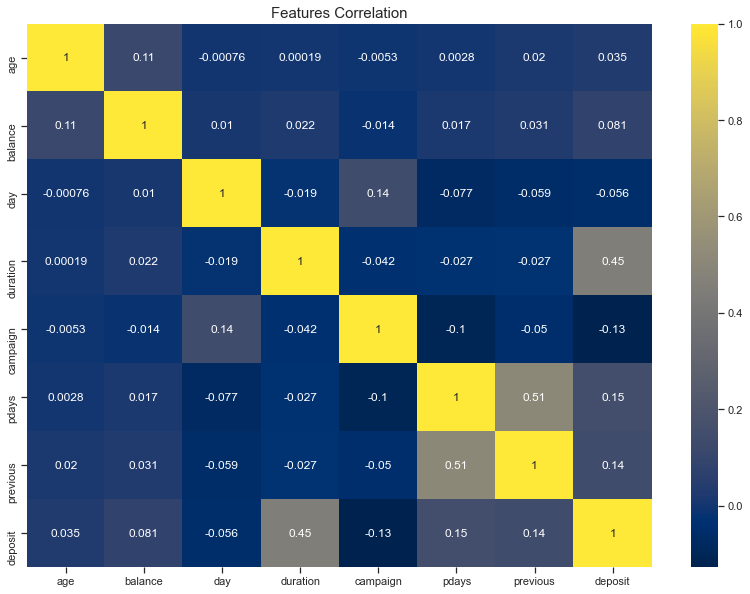

In [318]:
# examining correlation between numerical features
plt.figure(figsize = (14, 10))
sns.heatmap(dataset.corr(), annot = True, cmap= 'cividis')
plt.title("Features Correlation", fontsize = 15)

The result ranges from moderately correlated (0.51) to weak correlation of -0.13. If any two of the features were highly correlated, we can predict one from the other; one of the features would have been dropped because the model only requires one of them, as the other does not provide any extra information. 

In [319]:
# sorting dependent variable and all other variables
corr_matrix = dataset.corr()
corr_matrix["deposit"].sort_values(ascending=False)

deposit     1.000000
duration    0.451919
pdays       0.151593
previous    0.139867
balance     0.081129
age         0.034901
day        -0.056326
campaign   -0.128081
Name: deposit, dtype: float64

In [320]:
#Finding what percentage of missing data in the dataset
total = dataset.isnull().sum().sort_values(ascending=False)
percent_1 = dataset.isnull().sum()/dataset.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(6)

,Total,%
age,0,0.0
job,0,0.0
marital,0,0.0
education,0,0.0
default,0,0.0
balance,0,0.0


In [321]:
# class array variables
dataset.deposit.unique()

array([1, 0], dtype=int64)

In [322]:
# checking class distribution
dataset['deposit'].value_counts()

0    5873
1    5289
Name: deposit, dtype: int64

<AxesSubplot:xlabel='deposit', ylabel='count'>

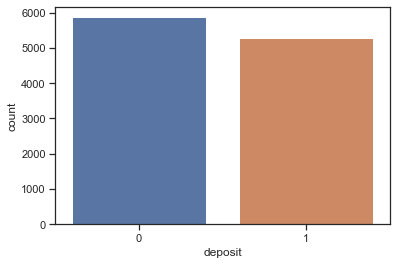

In [323]:
# Vizualizing the class distribution
sns.countplot(x='deposit', data=dataset)

This showed an almost equal distribution of the customers' response to deposit subscription 

# RELATIONSHIP BETWEEN TARGET CLASS WITH OTHER FEATURES

<AxesSubplot:xlabel='age'>

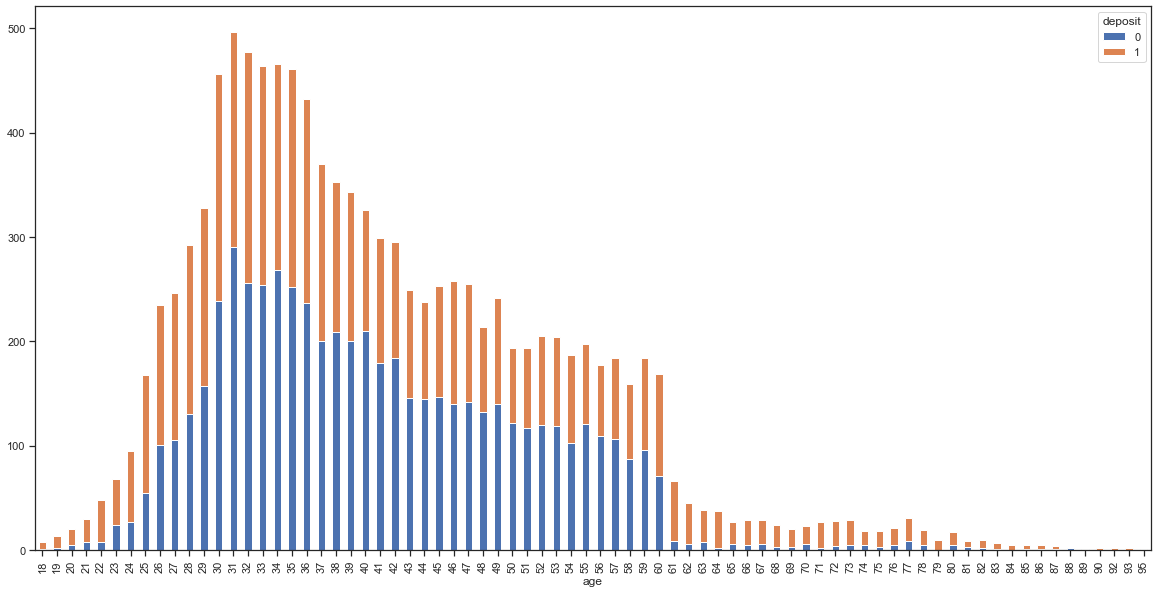

In [324]:
# age and deposit
pd.crosstab(dataset.age,dataset.deposit).plot(kind='bar', figsize=(20,10), stacked=True)

In [325]:
# the statistical interpretation of age and deposit 
dataset.groupby('age').deposit.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

age  deposit
18   1           87.5%
     0           12.5%
19   1           84.6%
     0           15.4%
20   1           75.0%
                 ...  
89   0          100.0%
90   1          100.0%
92   1          100.0%
93   1          100.0%
95   1          100.0%
Name: deposit, Length: 144, dtype: object

In [326]:
# the statistical interpretation: duration and deposit 
dataset.groupby('duration').deposit.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

duration  deposit
2         0          100.0%
3         0          100.0%
4         0          100.0%
5         0          100.0%
6         0          100.0%
                      ...  
3102      1          100.0%
3183      1          100.0%
3253      1          100.0%
3284      0          100.0%
3881      1          100.0%
Name: deposit, Length: 2157, dtype: object

The customers who were reached for a longer duration in the last campaign tends to subscribe to the term deposit compared to those who barely interacted beyond 60 seconds duration.

<AxesSubplot:xlabel='campaign'>

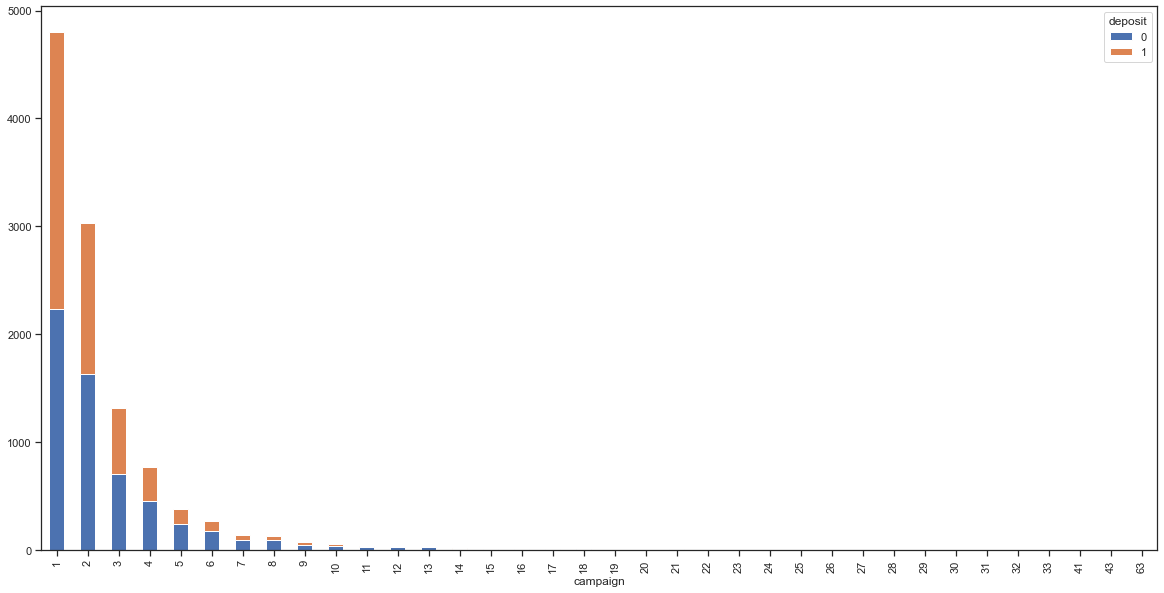

In [327]:
# campaign and deposit
pd.crosstab(dataset.campaign,dataset.deposit).plot(kind='bar', figsize=(20,10), stacked=True)

In [328]:
# the statistical interpretation: campaign and deposit 
dataset.groupby('campaign').deposit.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

campaign  deposit
1         1           53.4%
          0           46.6%
2         0           53.7%
          1           46.3%
3         0           53.2%
          1           46.8%
4         0           58.9%
          1           41.1%
5         0           63.2%
          1           36.8%
6         0           65.3%
          1           34.7%
7         0           66.2%
          1           33.8%
8         0           75.0%
          1           25.0%
9         0           70.8%
          1           29.2%
10        0           73.1%
          1           26.9%
11        0           60.0%
          1           40.0%
12        0           86.2%
          1           13.8%
13        0           80.0%
          1           20.0%
14        0           73.3%
          1           26.7%
15        0           69.2%
          1           30.8%
16        0           77.8%
          1           22.2%
17        0           57.1%
          1           42.9%
18        0          100.0%
19

There is an indirect relationship between the target variable and the choice of subscribing to the term deposit. Those who were reached more than ten times tends not to subscribe to the deposit.

<AxesSubplot:xlabel='loan'>

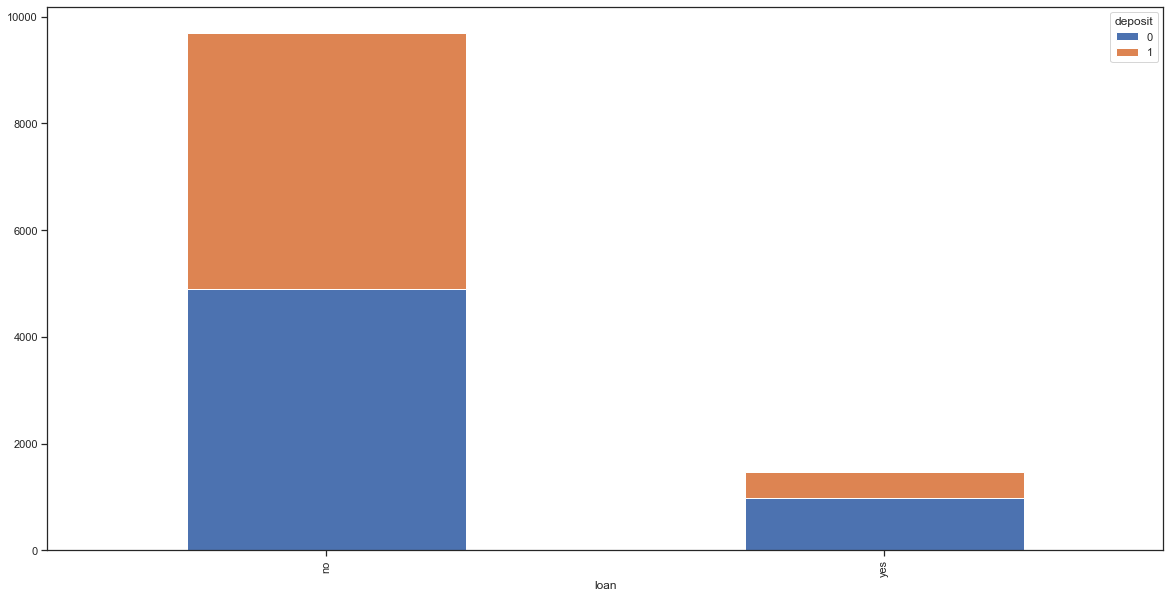

In [329]:
# loan and deposit
pd.crosstab(dataset.loan,dataset.deposit).plot(kind='bar', figsize=(20,10), stacked=True)

In [330]:
# the statistical interpretation: loan and deposit 
dataset.groupby('loan').deposit.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

loan  deposit
no    0          50.5%
      1          49.5%
yes   0          66.8%
      1          33.2%
Name: deposit, dtype: object

Those servicing personal loan are most likely not to subscribe for the term deposit

<AxesSubplot:xlabel='day'>

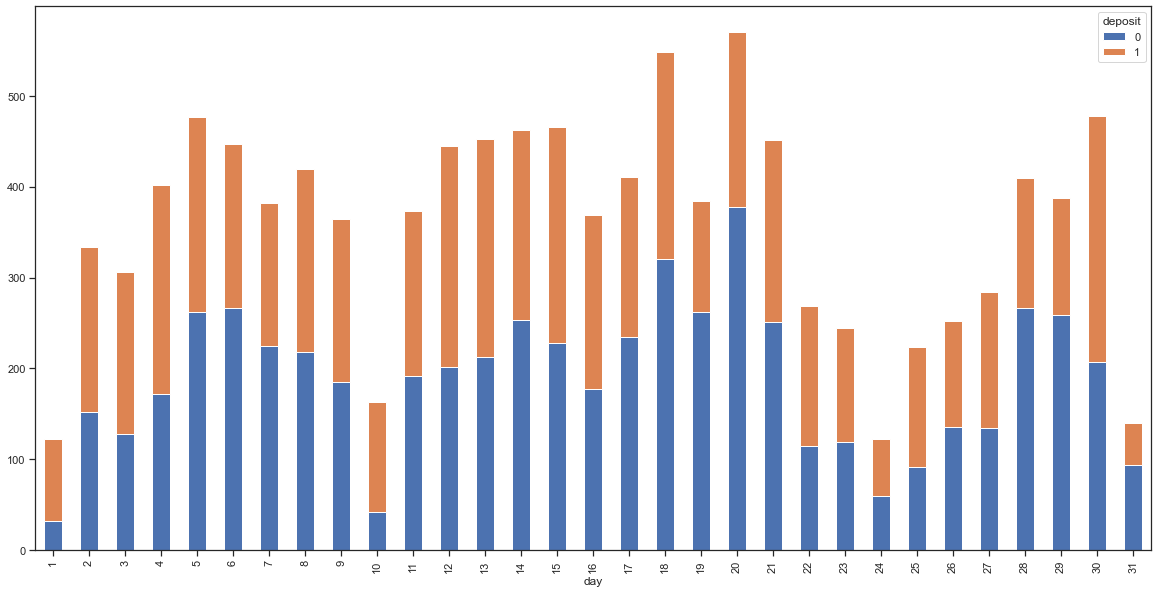

In [331]:
# day and deposit
pd.crosstab(dataset.day,dataset.deposit).plot(kind='bar', figsize=(20,10), stacked=True)

In [332]:
# the statistical interpretation: day and deposit 
dataset.groupby('day').deposit.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

day  deposit
1    1          73.8%
     0          26.2%
2    1          54.5%
     0          45.5%
3    1          58.2%
                ...  
29   1          33.2%
30   1          56.7%
     0          43.3%
31   0          67.1%
     1          32.9%
Name: deposit, Length: 62, dtype: object

In [333]:
# the statistical interpretation: loan and deposit 
dataset.groupby('loan').deposit.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

loan  deposit
no    0          50.5%
      1          49.5%
yes   0          66.8%
      1          33.2%
Name: deposit, dtype: object

Just one-third (33.2%) of customers having loan to service subscribed. People with no loan to repay tends to subscribe.

<AxesSubplot:xlabel='education'>

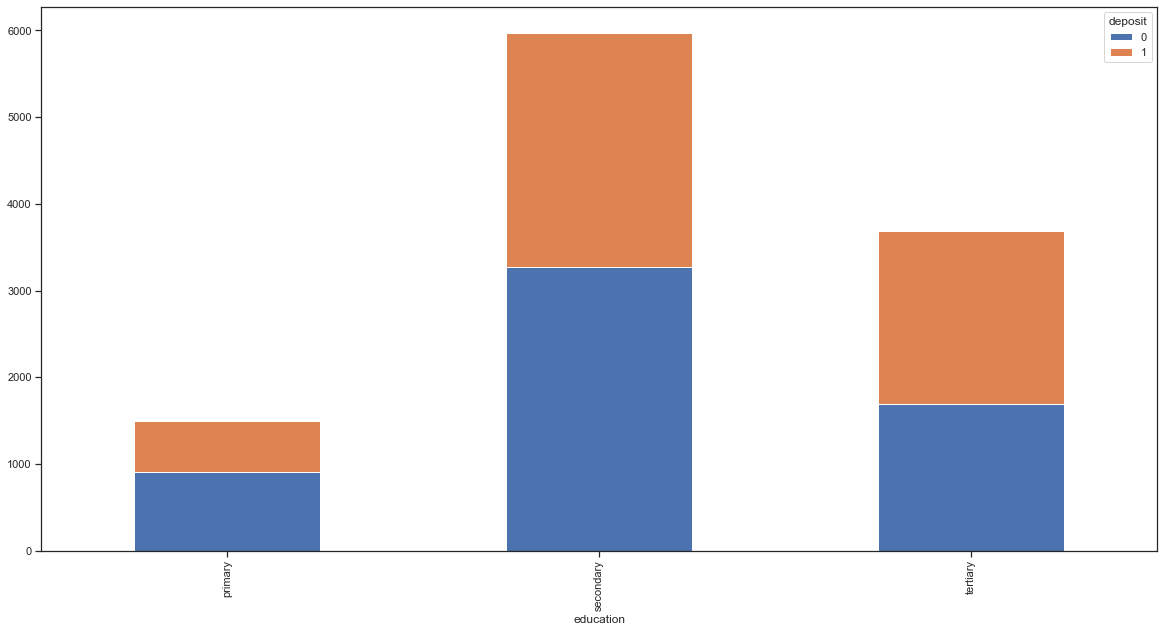

In [334]:
# education level determines the deposit 
pd.crosstab(dataset.education,dataset.deposit).plot(kind='bar', figsize=(20,10), stacked=True)

In [335]:
# the statistical interpretation: education and deposit 
dataset.groupby('education').deposit.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

education  deposit
primary    0          60.6%
           1          39.4%
secondary  0          54.8%
           1          45.2%
tertiary   1          54.1%
           0          45.9%
Name: deposit, dtype: object

The probability that a customer with a primary school education would not subscribe is high. The bank needs to target customers having the secondary and tertiary qualification as they tend to have higher likelihood of subscribing to term deposit.

<AxesSubplot:xlabel='job'>

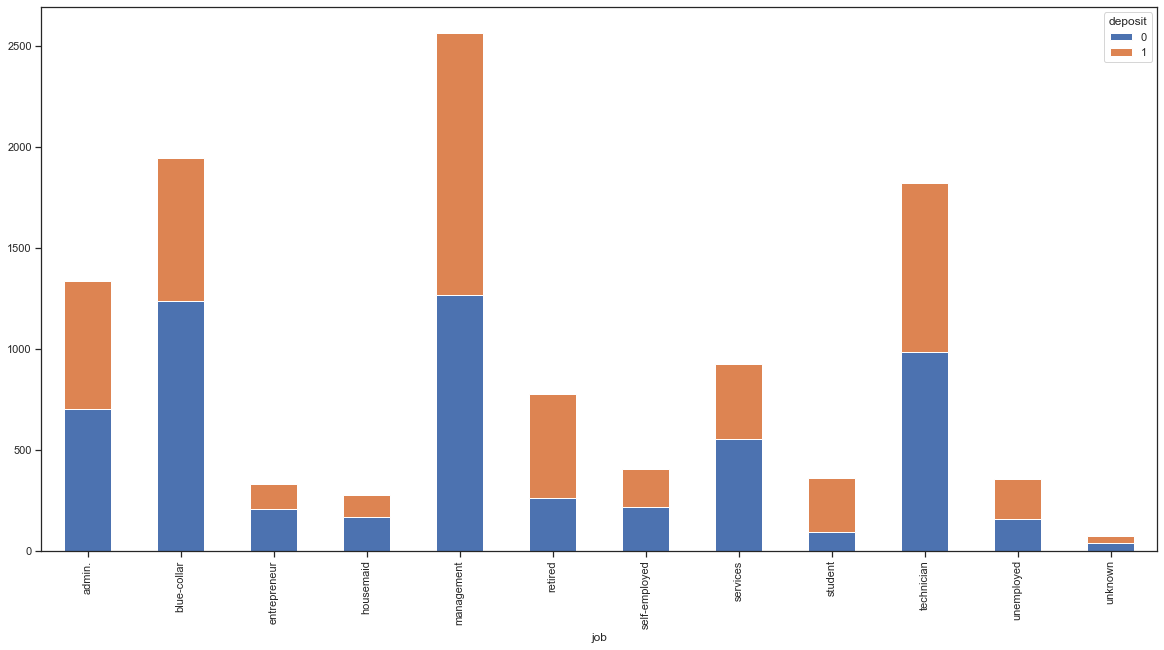

In [336]:
# job and deposit
pd.crosstab(dataset.job, dataset.deposit).plot(kind='bar', figsize=(20,10), stacked=True)

In [337]:
# the statistical interpretation: job and deposit 
dataset.groupby('job').deposit.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

job            deposit
admin.         0          52.7%
               1          47.3%
blue-collar    0          63.6%
               1          36.4%
entrepreneur   0          62.5%
               1          37.5%
housemaid      0          60.2%
               1          39.8%
management     1          50.7%
               0          49.3%
retired        1          66.3%
               0          33.7%
self-employed  0          53.8%
               1          46.2%
services       0          60.0%
               1          40.0%
student        1          74.7%
               0          25.3%
technician     0          53.9%
               1          46.1%
unemployed     1          56.6%
               0          43.4%
unknown        0          51.4%
               1          48.6%
Name: deposit, dtype: object

There is tendency that a retiree would subscribe than anyone with jobs is higher (66.3%)

<AxesSubplot:xlabel='marital'>

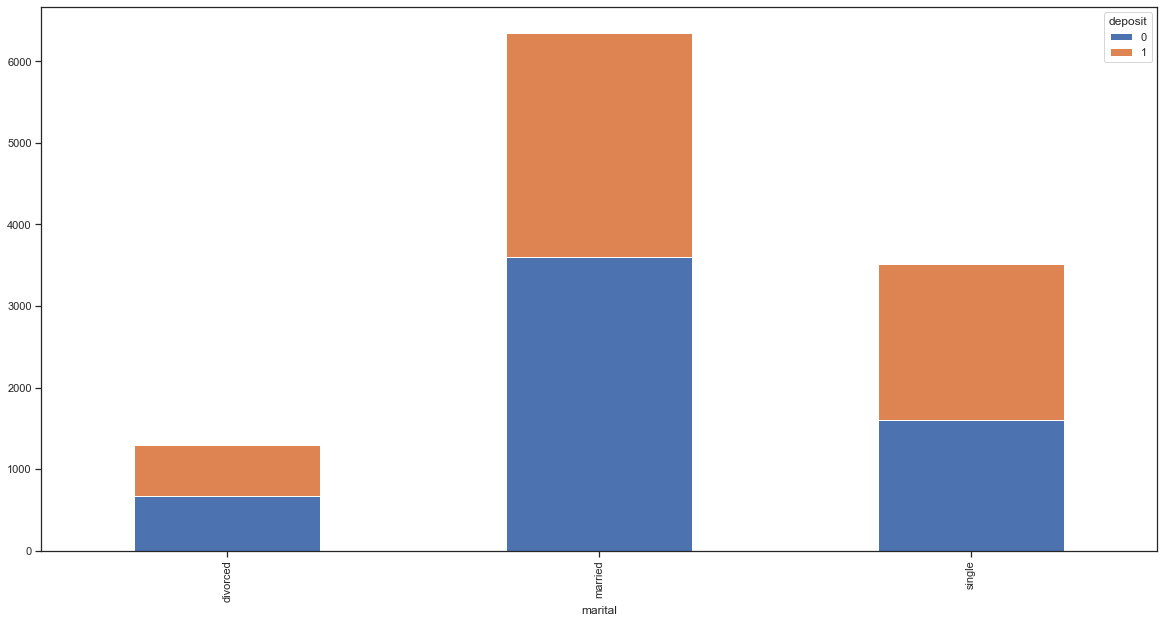

In [338]:
# marital and deposit
pd.crosstab(dataset.marital, dataset.deposit).plot(kind='bar', figsize=(20,10), stacked=True)

In [339]:
# the statistical interpretation: marital and deposit 
dataset.groupby('marital').deposit.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

marital   deposit
divorced  0          51.9%
          1          48.1%
married   0          56.6%
          1          43.4%
single    1          54.3%
          0          45.7%
Name: deposit, dtype: object

Singles are likely more likely to subscribe.

<AxesSubplot:xlabel='month'>

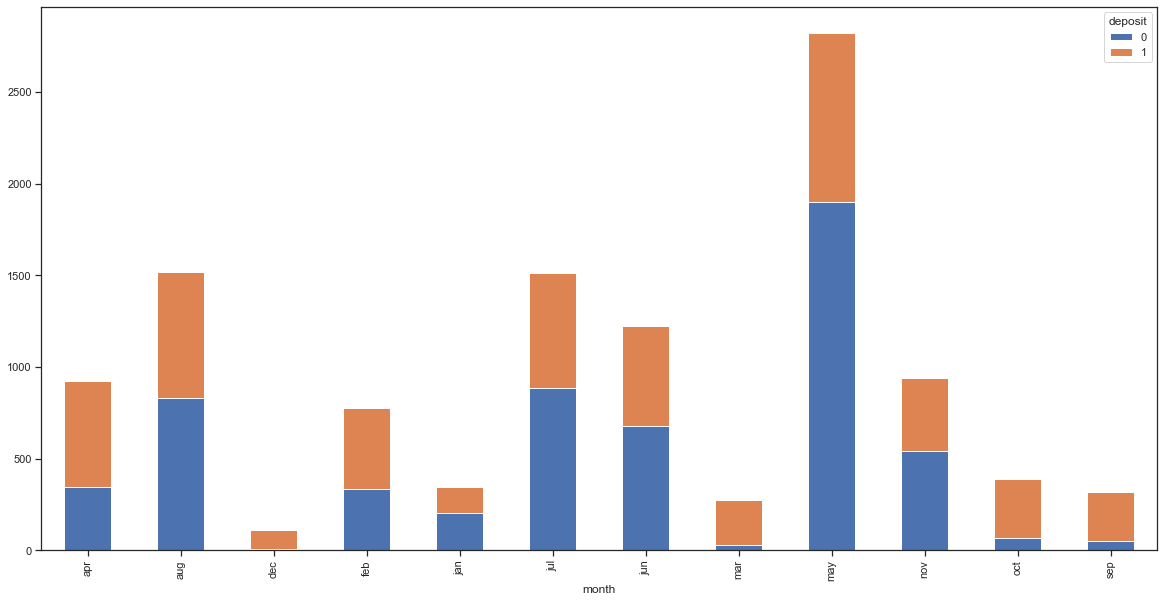

In [340]:
# month and deposit
pd.crosstab(dataset.month, dataset.deposit).plot(kind='bar', figsize=(20,10), stacked=True)

In [341]:
# the statistical interpretation: month and deposit 
dataset.groupby('month').deposit.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

month  deposit
apr    1          62.5%
       0          37.5%
aug    0          54.7%
       1          45.3%
dec    1          90.9%
       0           9.1%
feb    1          56.8%
       0          43.2%
jan    0          58.7%
       1          41.3%
jul    0          58.6%
       1          41.4%
jun    0          55.3%
       1          44.7%
mar    1          89.9%
       0          10.1%
may    0          67.2%
       1          32.8%
nov    0          57.3%
       1          42.7%
oct    1          82.4%
       0          17.6%
sep    1          84.3%
       0          15.7%
Name: deposit, dtype: object

The possibility that potential client reached by the campaign in the month of March, September, October and December would subscribe is high.

<AxesSubplot:xlabel='default'>

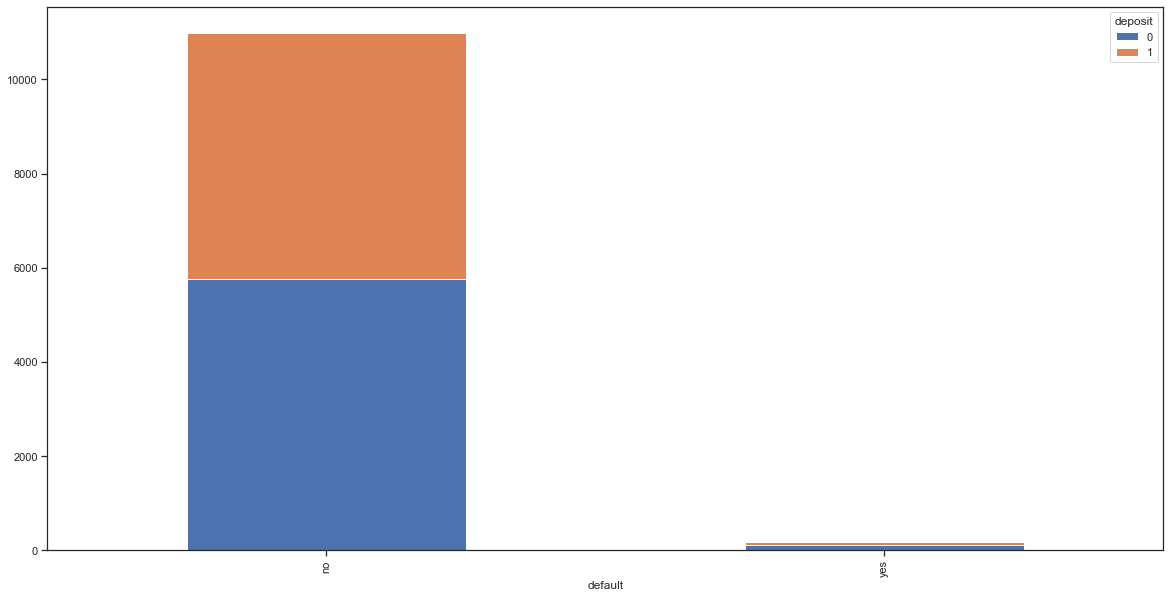

In [342]:
# default and deposit
pd.crosstab(dataset.default, dataset.deposit).plot(kind='bar', figsize=(20,10), stacked=True)

In [343]:
# the statistical interpretation: default and deposit 
dataset.groupby('default').deposit.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

default  deposit
no       0          52.4%
         1          47.6%
yes      0          69.0%
         1          31.0%
Name: deposit, dtype: object

Customers with credit in default are more likely not to subscribe.

<AxesSubplot:xlabel='housing'>

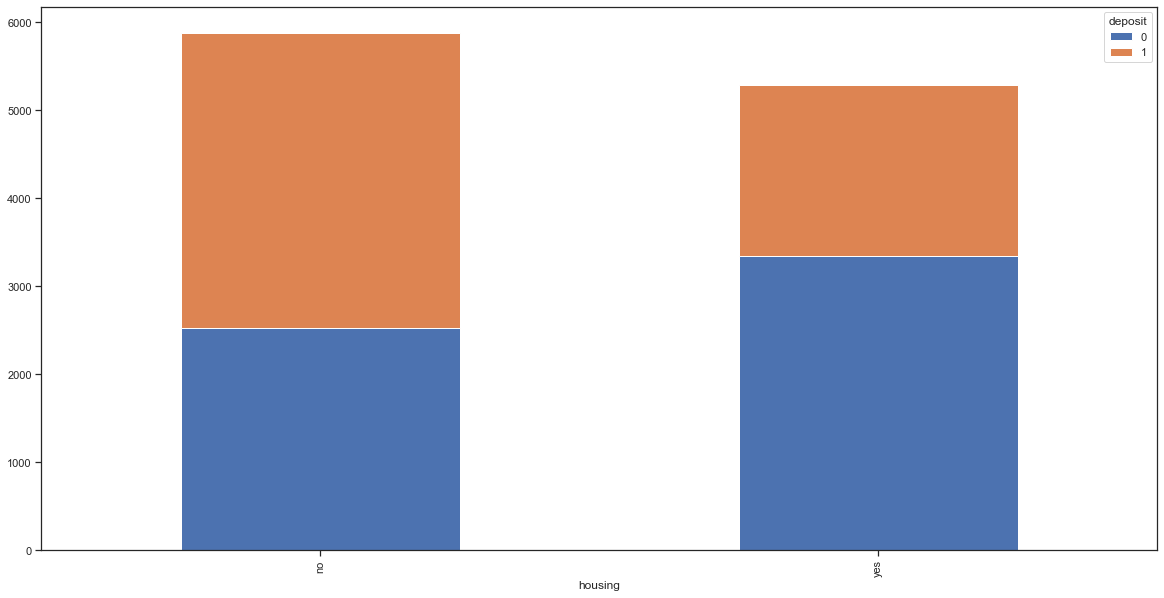

In [344]:
# housing and deposit
pd.crosstab(dataset.housing,dataset.deposit).plot(kind='bar', figsize=(20,10), stacked=True)

In [345]:
# the statistical interpretation: housing and deposit 
dataset.groupby('housing').deposit.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

housing  deposit
no       1          57.0%
         0          43.0%
yes      0          63.4%
         1          36.6%
Name: deposit, dtype: object

Those with housing loan will most likely not subscribe to the term deposit.

# Outliers

<AxesSubplot:xlabel='campaign'>

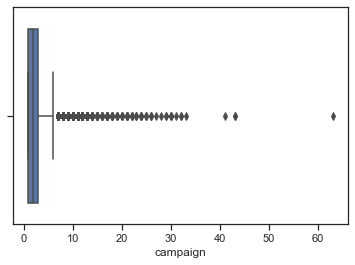

In [346]:
# outliers in [pdays, previous, campaign, duration]features

sns.boxplot(x='campaign', data=dataset)

<AxesSubplot:xlabel='pdays'>

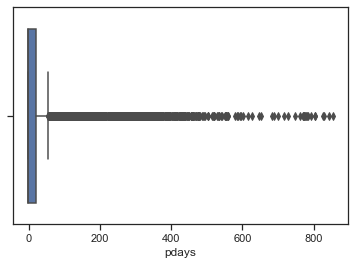

In [347]:
sns.boxplot(x='pdays', data=dataset)

<AxesSubplot:xlabel='previous'>

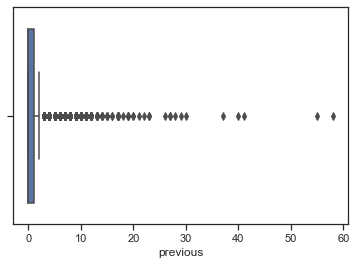

In [348]:
sns.boxplot(x='previous', data=dataset)

<AxesSubplot:xlabel='duration'>

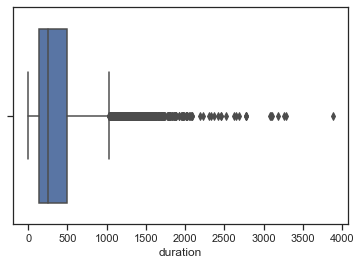

In [349]:
sns.boxplot(x='duration', data=dataset)

In [350]:
# Checking the minimum and maximum value of outliers
min_pdays, max_pdays = dataset['pdays'].quantile([0.25,0.75])
min_previous, max_previous = dataset['previous'].quantile([0.25,0.75])
min_campaign, max_campaign = dataset['campaign'].quantile([0.25,0.75])
min_duration, max_duration = dataset['duration'].quantile([0.25,0.75])
min_campaign, max_campaign

(1.0, 3.0)

In [351]:
# number values not in outliers in pdays feature
count =0
for i in dataset['pdays']:
    if (i > min_pdays) & (i < max_pdays):
        count+= 1
print(count)

47


In [352]:
# number values not in outliers in previous feature
count =0
for i in dataset['previous']:
    if (i > min_previous) & (i < max_previous):
        count+= 1
print(count)

0


In [353]:
# number values not in outliers in campaign feature
count =0
for i in dataset['campaign']:
    if (i > min_campaign) & (i < max_campaign):
        count+= 1
print(count)

3028


In [354]:
# number values not in outliers in duration feature
count =0
for i in dataset['duration']:
    if (i > min_duration) & (i < max_duration):
        count+= 1
print(count)

5569


In [355]:
# Since the value of Outliers is high. adjustment is made
def outliers(df,fxn):
#     Q1= df[fxn].quantile(0.25)
# In order to avoid undersampling, the first quartile was adjusted to 20th percentile
    Q1= df[fxn].quantile(0.20)
    
#     Q3= df[fxn].quantile(0.75)
# In order to avoid undersampling, the third quartile was adjusted to 85th percentile  
    Q3= df[fxn].quantile(0.85)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - (1.5*IQR)
    upper_bound = Q3 + (1.5*IQR)
    
    ls = df.index[(df[fxn] < lower_bound) | (df[fxn] > upper_bound)]
    
    return ls



In [356]:
# output of outliers indices from features

index_list = []
for feature in ['pdays', 'previous', 'campaign', 'duration']:
    index_list.extend(outliers(dataset, feature))

In [357]:
# Checking thye amount of outliers
print(len(index_list))

978


In [358]:
def remove_outliers(df,ls):
    ls = sorted(set(ls))
    df = df.drop(ls)
    
    return df

In [359]:
# Removing outliers in [pdays, previous, campaign, duration]
df_cleaned =remove_outliers(dataset, index_list)

In [360]:
df_cleaned.shape

(10202, 15)

# Multivariate Analysis

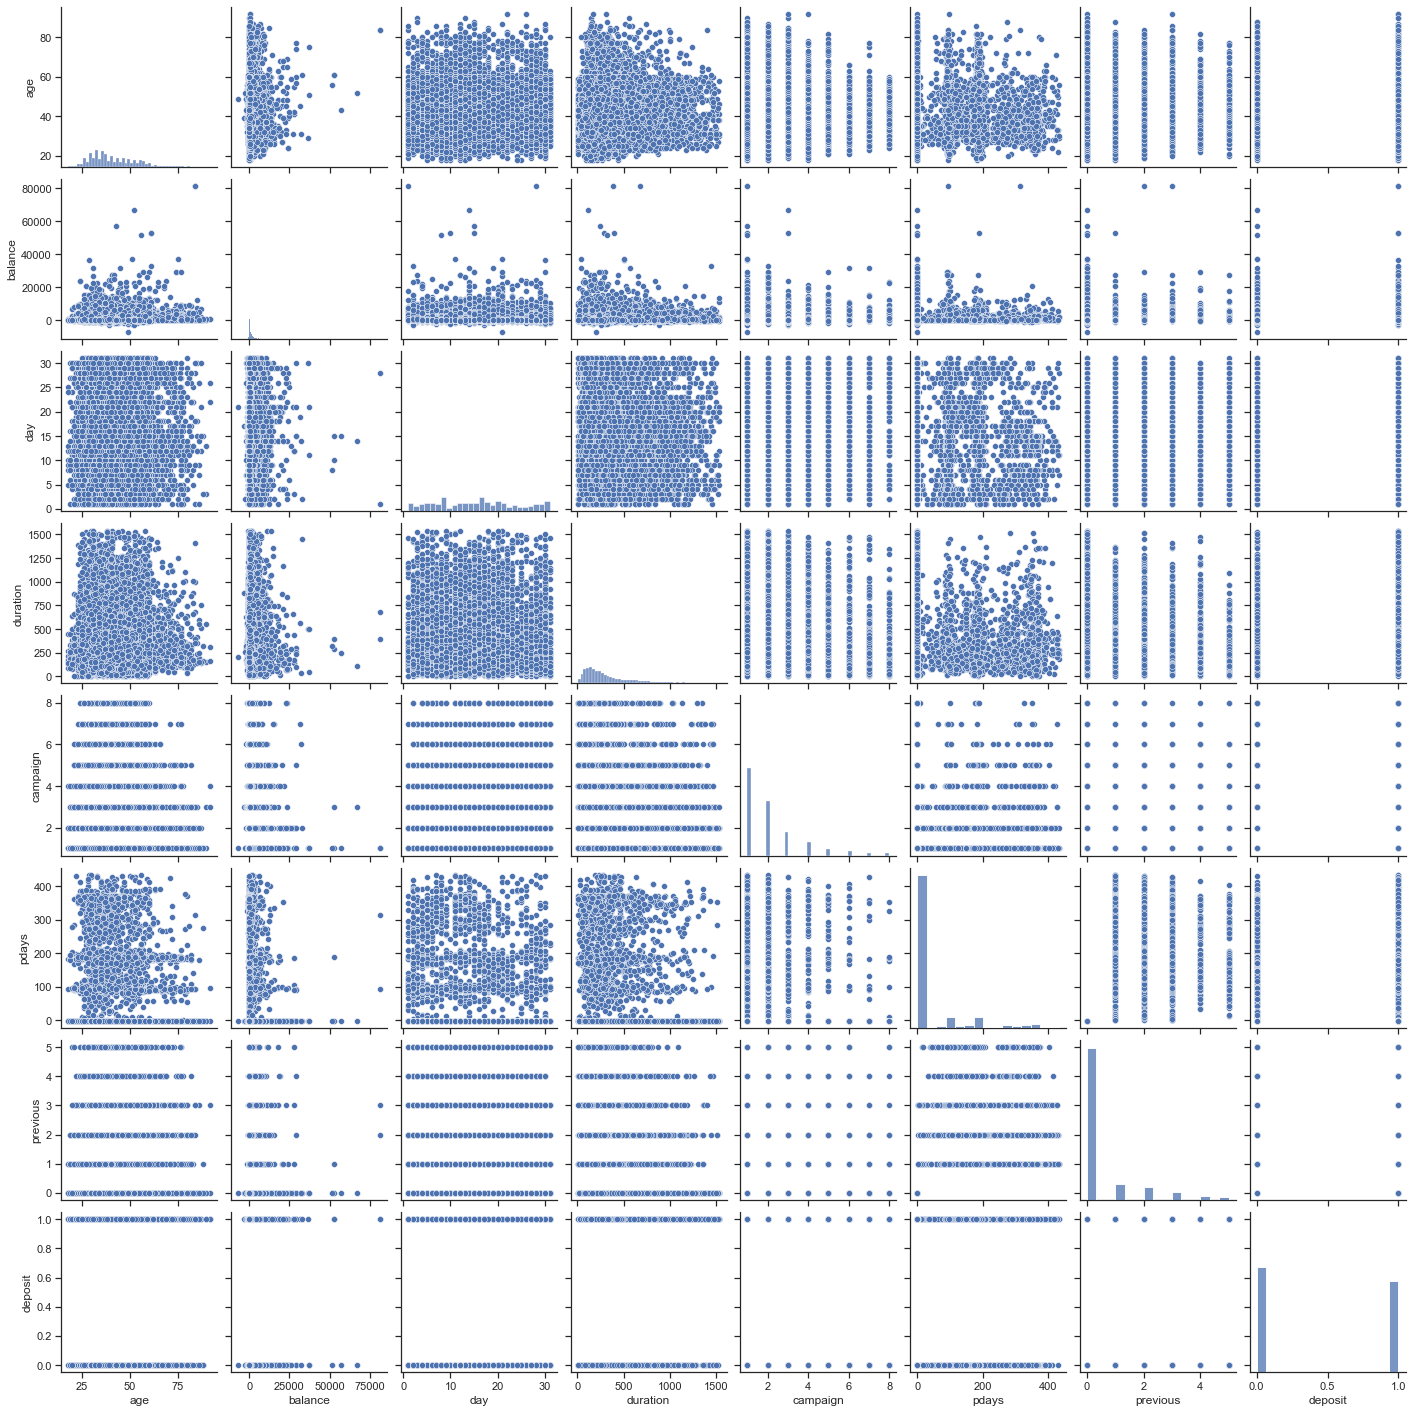

In [361]:
sns.pairplot(df_cleaned)

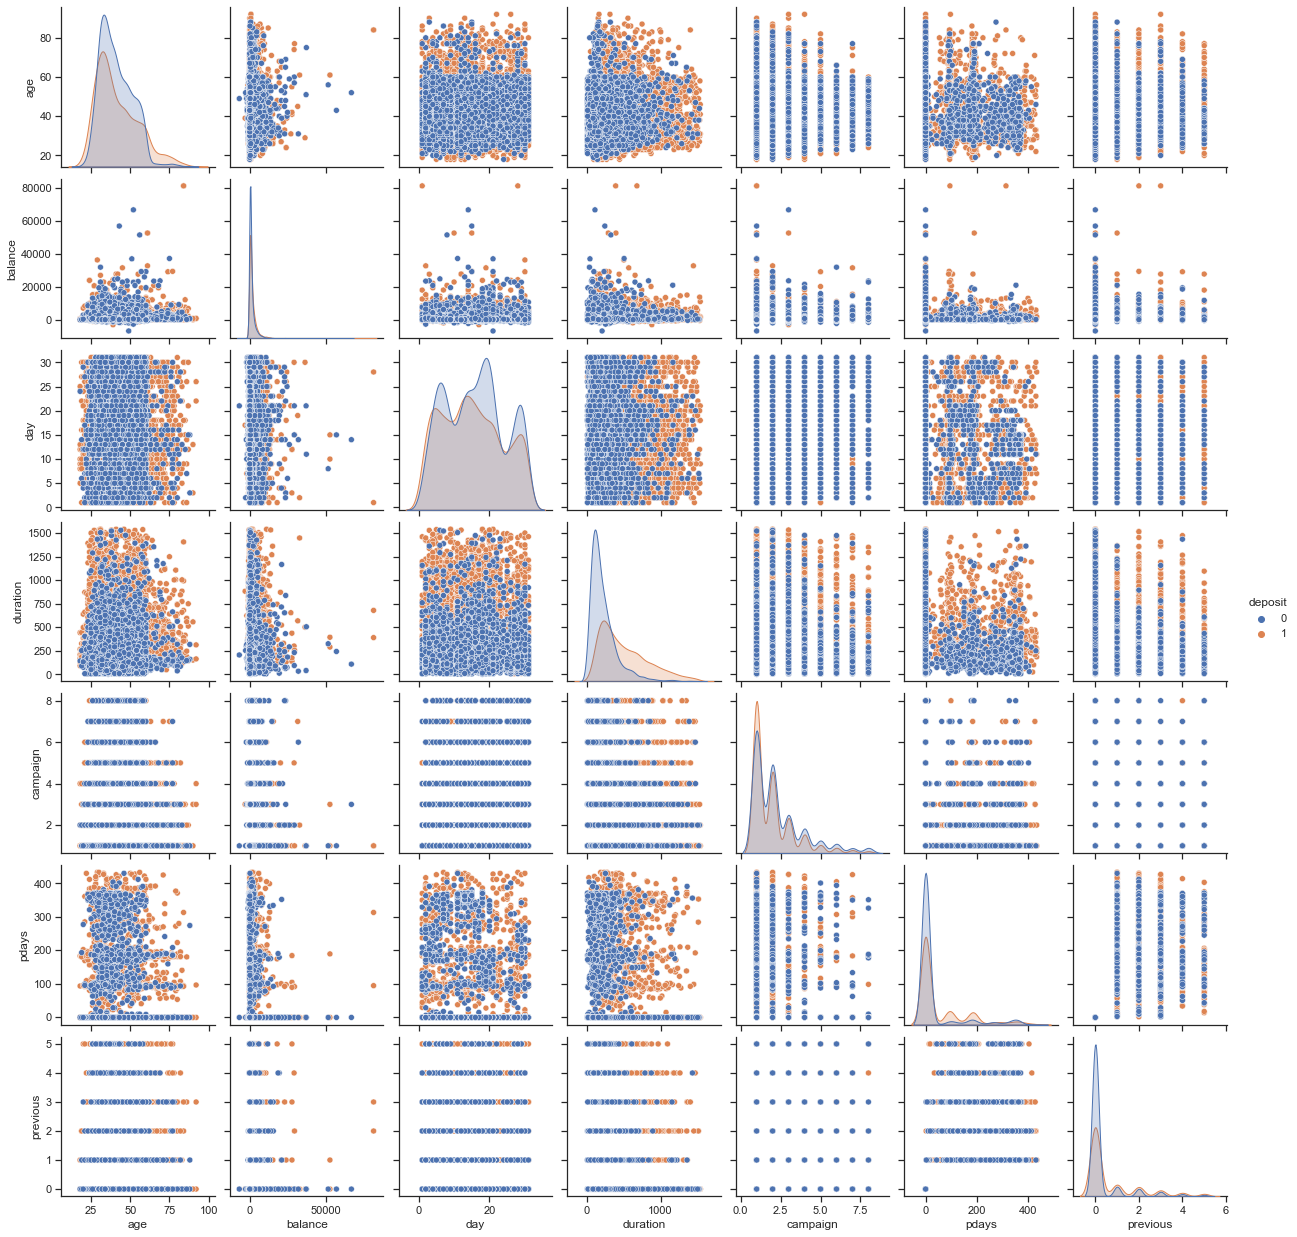

In [362]:
# visualising relationship between features
sns.set(style="ticks")

sns.pairplot(data=df_cleaned, hue="deposit")
plt.show()

In [363]:
# CHECKING DISTIBUTION OF DATA WITHIN THE INDIVIDUAL FEATURES
# df_cleaned.hist(bins=20, figsize=(14,10), color='#E14906')

In [364]:
df_cleaned.shape

(10202, 15)

In [365]:
#  defining inputs and output class
X= df_cleaned.copy()
y = X.pop('deposit')

y.shape


(10202,)

In [366]:
X.shape

(10202, 14)

# Data Preprocessing

In [367]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.values
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = X.select_dtypes(include='object').columns.values
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [368]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# LogisticRegression Classifier

model score: 0.796
              precision    recall  f1-score   support

           0       0.79      0.84      0.82      1643
           1       0.80      0.74      0.77      1418

    accuracy                           0.80      3061
   macro avg       0.80      0.79      0.79      3061
weighted avg       0.80      0.80      0.80      3061



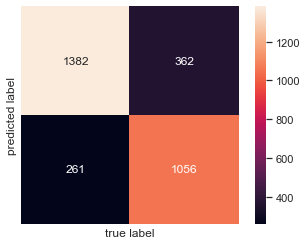

In [369]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
model_logreg = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, 
                           l1_ratio=None, max_iter=100, multi_class='auto', n_jobs=None, penalty='l2', 
                           random_state=None, solver='lbfgs', tol=0.0001, verbose=0, 
                           warm_start=False))]
)


model_logreg.fit(X_train, y_train)
print("model score: %.3f" % model_logreg.score(X_test, y_test))

# Confusion Matrix
cm = confusion_matrix(y_test, model_logreg.predict(X_test))
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=True, xticklabels= '', yticklabels='')
plt.xlabel('true label')
plt.ylabel('predicted label');

print(classification_report(y_test, model_logreg.predict(X_test)))

# DecisionTree Classifier

model score: 0.751
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1643
           1       0.73      0.73      0.73      1418

    accuracy                           0.75      3061
   macro avg       0.75      0.75      0.75      3061
weighted avg       0.75      0.75      0.75      3061



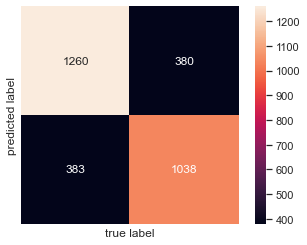

In [370]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
model_dec = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier(criterion= 'entropy', random_state= 100, max_depth= 3))]
)


model_dec.fit(X_train, y_train)
print("model score: %.3f" % model_dec.score(X_test, y_test))

# Confusion Matrix
cm = confusion_matrix(y_test, model_dec.predict(X_test))
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=True, xticklabels= '', yticklabels='')
plt.xlabel('true label')
plt.ylabel('predicted label');


print(classification_report(y_test, model_dec.predict(X_test)))

# RandomForest Classifier

model score: 0.833
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1643
           1       0.80      0.85      0.82      1418

    accuracy                           0.83      3061
   macro avg       0.83      0.83      0.83      3061
weighted avg       0.83      0.83      0.83      3061



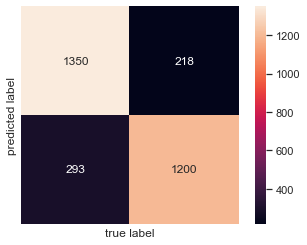

In [371]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
model_rforest = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(n_jobs=2, n_estimators=100, random_state=0))]
)


model_rforest.fit(X_train, y_train)
print("model score: %.3f" % model_rforest.score(X_test, y_test))

# Confusion Matrix
cm = confusion_matrix(y_test, model_rforest.predict(X_test))
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=True, xticklabels= '', yticklabels='')
plt.xlabel('true label')
plt.ylabel('predicted label');

print(classification_report(y_test, model_rforest.predict(X_test)))

# Printing the AUROC scores

In [372]:
# prediction probabilities
r_probs = [0 for _ in range(len(y_test))]

logreg_probs = model_logreg.predict_proba(X_test)
dtree_probs = model_dec.predict_proba(X_test)
forest_probs = model_rforest.predict_proba(X_test)

# Probabilities for the positive outcome is kept.
r_auc = roc_auc_score(y_test, r_probs)

logreg_probs = logreg_probs[:, 1]
dtree_probs = dtree_probs[:, 1]
forest_probs = forest_probs[:, 1]

# calculate scores(AUROC)
r_auc = roc_auc_score(y_test, r_probs)
logreg_auc = roc_auc_score(y_test, logreg_probs)
dtree_auc = roc_auc_score(y_test, dtree_probs)
rforest_auc = roc_auc_score(y_test, forest_probs)


# summarize scores
print('Random Prediction: ROC AUC=%.3f' % (r_auc))
print('Logistic: ROC AUC=%.3f' % (logreg_auc))
print('Decision Tree: ROC AUC=%.3f' % (dtree_auc))
print('Random Forest: ROC AUC=%.3f' % (rforest_auc))



Random Prediction: ROC AUC=0.500
Logistic: ROC AUC=0.883
Decision Tree: ROC AUC=0.812
Random Forest: ROC AUC=0.906


# Calculating the ROC Curve

In [373]:
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
logreg_fpr, logreg_tpr, _ = roc_curve(y_test, logreg_probs)
dtree_fpr, dtree_tpr, _ = roc_curve(y_test, dtree_probs)
rforest_fpr, rforest_tpr, _ = roc_curve(y_test, forest_probs)

# Plotting the ROC Curve

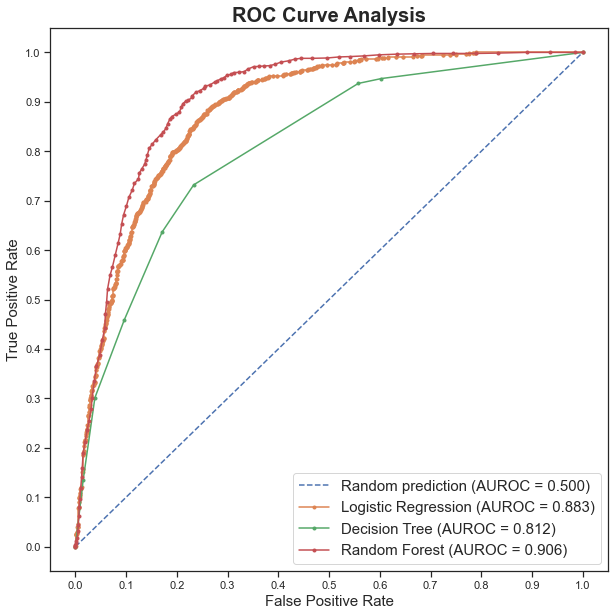

In [374]:
fig = plt.figure(figsize=(10,10))

plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(logreg_fpr, logreg_tpr, marker='.', label='Logistic Regression (AUROC = %0.3f)' % logreg_auc)
plt.plot(dtree_fpr, dtree_tpr, marker='.', label='Decision Tree (AUROC = %0.3f)' % dtree_auc)
plt.plot(rforest_fpr, rforest_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rforest_auc)

# Title
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=20)

# Axis labels
# plt.xticks(np.arange(0.0,1.1,0.1))
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel('False Positive Rate', fontsize= 15)
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel('True Positive Rate', fontsize= 15)
# Show legend
plt.legend(prop={'size':15}, loc='lower right')

# Show plot
plt.show()

# Plotting the Decision Tree

Text(0.5, 1.0, 'Decision tree trained on all the bank features')

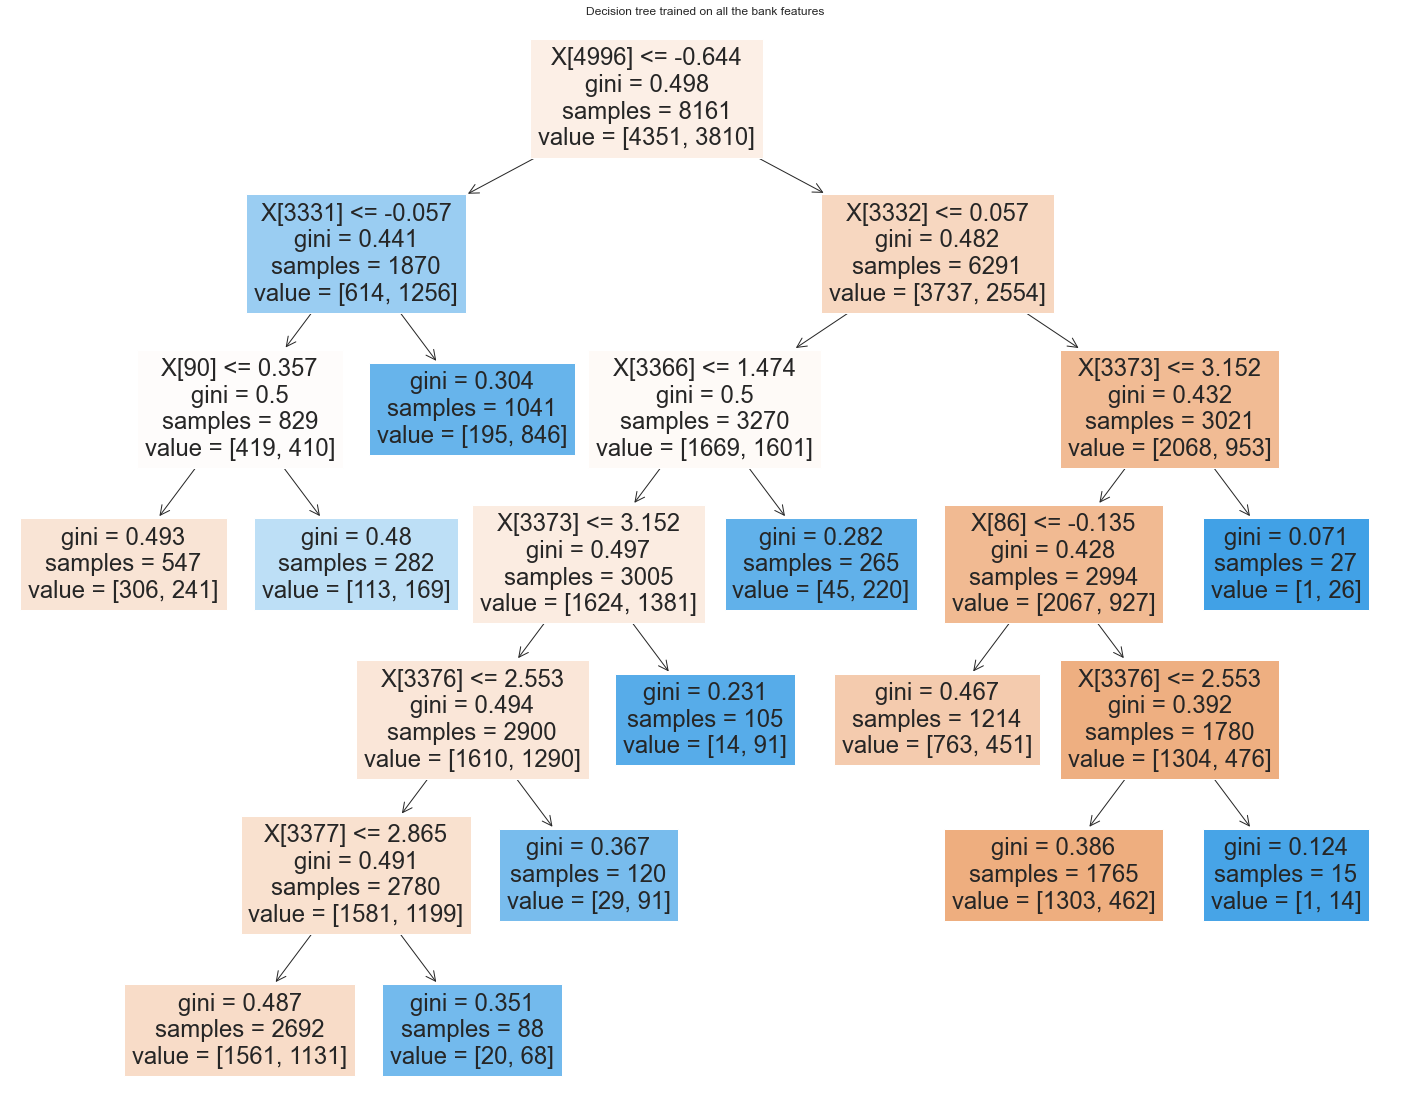

In [375]:
from sklearn import preprocessing
from sklearn.tree import plot_tree

datas = df_cleaned.copy()

target = datas.pop('deposit')

x_train, x_test, y_train, y_test = train_test_split(datas, target, test_size=0.2, random_state=0)

le = preprocessing.OneHotEncoder(handle_unknown="ignore", sparse=False)
x_train = le.fit_transform(x_train)
x_test = le.transform(x_test)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

dt = DecisionTreeClassifier(max_depth=6, max_leaf_nodes=12).fit(x_train, y_train)

plt.figure(figsize=(25,20))
plot_tree(dt, filled=True)
plt.title("Decision tree trained on all the bank features")